<a href="https://colab.research.google.com/github/Landcruiser87/7333_QTW/blob/master/ah_CS12_higgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This case study has set its sights on neural networks.  Specifically focused on high energy physics of Higgs Bosons!  An exciting field in physics that deals with very fast, high energy collisions that quickly decay into other particles.  These exotic Higgs Bosons form and decay so quickly that they can't be directly observed, but the decayed product particles can be observed.  The process of classifying these particles is found by comparing the direction and momentum of the decayed particle.  Our task is to recreate the deep neural network used by P. Baldi et all and try to improve upon the models performance by implementing modern machine learning tools that have been developed since the release of this paper. 

# Background

The dataset created by P. Baldi et all consists of 11 million records of high energy collisions with 21 observable features and 7 manufactured features that aide physicists to classify the type of resulting particles.  After careful examination of the paper we deduced the following parameters to have been used in creation of their model.  

- Neurons = 300 per Layer
- Number of Layers = 5 Layers
- Normalization - 0 to 1
- Activation Function = tanh for the first layers, sigmoid for the last
- Learning Rate = 0.05
- Learning Rate Decay = .00001
- Momentum = 0.9
- Metrics = AUC, Accuracy
- Epoch's = 1000
- Batch Size = 100

Next because of the massive size of this dataset, we sub sample 100k rows in order to reduce computation time with training the neural network.  Initial testing on the full dataset was around 3 to 4 minutes per epoch even using Google Colab's GPU core for analysis.  By sampling 100k records, we can get that time down to 2 seconds per epoch which is far more advantageous for development.  We utilize an 80/20 train/test split and use AUC (Area under the Curve) and accuracy as our performance metrics.  

In [1]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
print(tf.__version__)


2.2.0-rc1


# Analysis

### Baseline Model Replication
Next, we input the parameters described above into action in order to rebuild P. Baldi et all's deep neural network.  We import the directly from the [UCI repository.](https://archive.ics.uci.edu/ml/datasets/HIGGS#) and create some basic histograms see what type of ranges our features exhibit.  

In [0]:
#Importing dataset.  FROM THE WEB.  Because we're rebels.  With small hard drives. 

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
col_names = ['Target','lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
             'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 
             'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
full_higgs_df = pd.read_csv(url, header=None, names=col_names)

# Old Import routine.
# from google.colab import files
# import io
# uploaded = files.upload()
# full_higgs_df = pd.read_csv(io.BytesIO(uploaded['HIGGS.csv']))


In [3]:
full_higgs_df.head(5)

,Target,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [4]:
#Taking the first 100k rows for faster analysis run times. 

small_higgs_df = pd.DataFrame(full_higgs_df.iloc[0:100000])
X = small_higgs_df.drop('Target', axis=1)
y = small_higgs_df.iloc[:,0]

print(X.shape)
print(y.shape)

#should probably run it through the standard scaler as well.  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)


(100000, 28)
(100000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases l

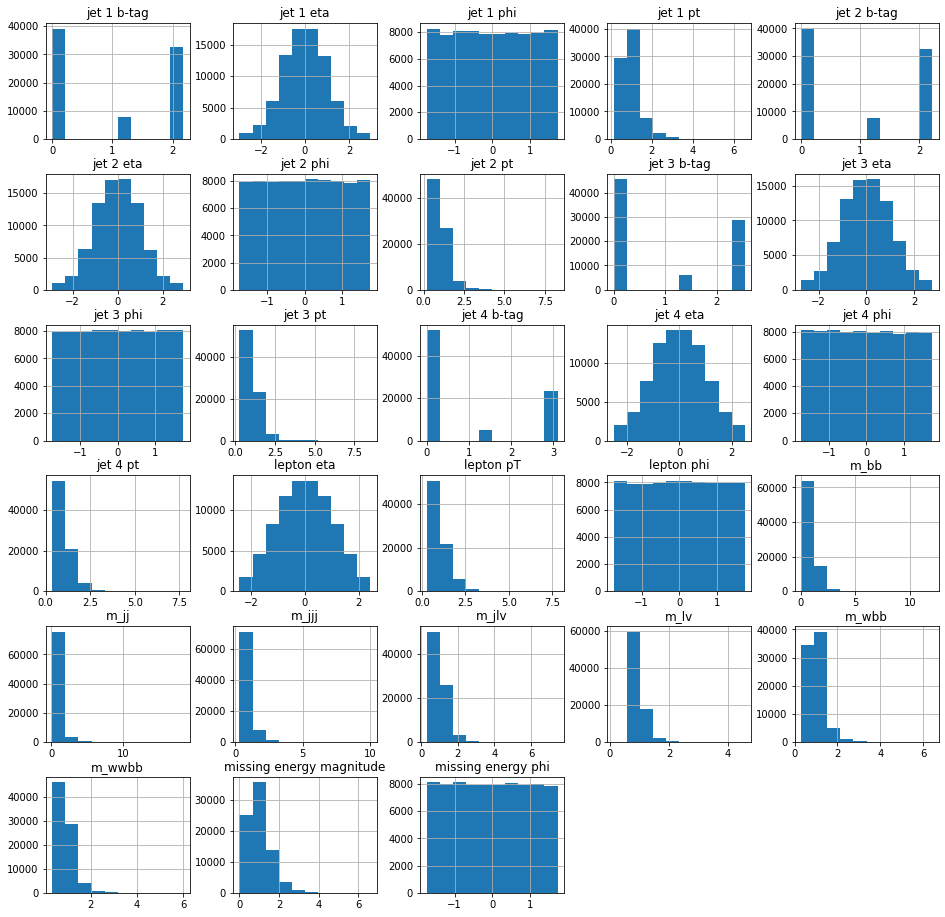

In [5]:
#Plotting some EDA over the variables before normalization. 

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (16,16))
ax = fig.gca()
X_train.hist(ax=ax)
plt.show()


### Model Replication

Below is our estimation of the 5 layer NN model used by P. Baldi et all.  

In [0]:
#Lets build that 5 layer dip!

model = tf.keras.Sequential()
model.add(layers.Dense(28, input_dim=28))
model.add(layers.Dense(300, activation = 'tanh'))
model.add(layers.Dense(300, activation = 'tanh'))
model.add(layers.Dense(300, activation = 'tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [0]:
optimiz = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=optimiz,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=100)

Epoch 1/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.6652 - accuracy: 0.5983
Epoch 2/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.6514 - accuracy: 0.6175
Epoch 3/1000
800/800 [==============================] - 1s 2ms/step - loss: 0.6389 - accuracy: 0.6356
Epoch 4/1000
800/800 [==============================] - 1s 2ms/step - loss: 0.6232 - accuracy: 0.6547
Epoch 5/1000
800/800 [==============================] - 1s 2ms/step - loss: 0.6153 - accuracy: 0.6622
Epoch 6/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.6068 - accuracy: 0.6696
Epoch 7/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.6024 - accuracy: 0.6745
Epoch 8/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.5990 - accuracy: 0.6764
Epoch 9/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.5962 - accuracy: 0.6797
Epoch 10/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.591

In [9]:
from sklearn.metrics import roc_auc_score
print("Train AUC:", roc_auc_score(np.asarray(y_train), model.predict(X_train.values)))
print("Test AUC:", roc_auc_score(np.asarray(y_test), model.predict(X_test.values)))

Train AUC: 0.9500575032501591
Test AUC: 0.723670777291036


In [1]:
model.summary()

NameError: ignored

ERROR! Session/line number was not unique in database. History logging moved to new session 60


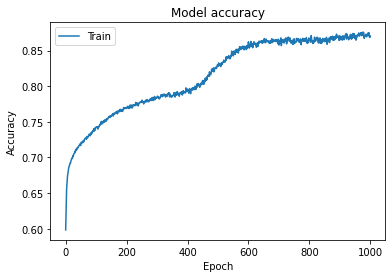

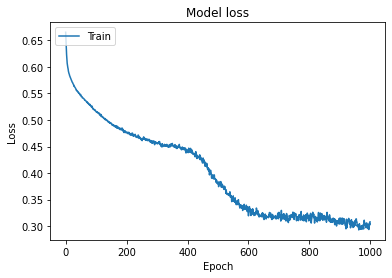

In [10]:
# Plotting accuracies for training
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plotting loss of training
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Model playground


In [0]:
model_fun = tf.keras.Sequential()
model_fun.add(layers.Dense(300, activation = 'tanh'))
model_fun.add(layers.Dense(300, activation = 'tanh'))
model_fun.add(layers.Dense(300, activation = 'tanh'))
model_fun.add(layers.Dropout(0.5))
model_fun.add(layers.Dense(1, activation = 'sigmoid'))

In [0]:
optimiz = tf.keras.optimizers.Adam(learning_rate=0.01,)
model_fun.compile(optimizer=optimiz,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [0]:
history_fun = model.fit(X_train, y_train, validation_split = 0.10, epochs=100, batch_size=100, verbose=0)

print("Train AUC:", roc_auc_score(np.asarray(y_train), model.predict(X_train.values)))
print("Test AUC:", roc_auc_score(np.asarray(y_test), model.predict(X_test.values)))


Train AUC: 0.9428687231888533
Test AUC: 0.733882939823608


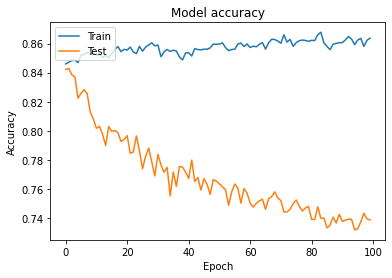

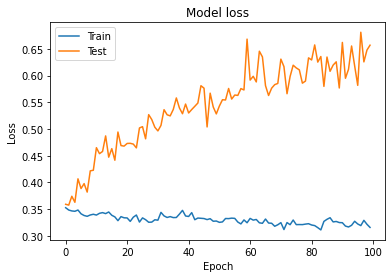

In [0]:
# Plotting accuracies of validation and training
plt.plot(history_fun.history['accuracy'])
plt.plot(history_fun.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting loss of training & validation
plt.plot(history_fun.history['loss'])
plt.plot(history_fun.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()